In [1]:
import pandas as pd
from sklearn import tree, neighbors, neural_network
from sklearn import metrics
import numpy as np
import graphviz 
import matplotlib.pyplot as plt

In [2]:
def split_sets(df, frac):
    training = df.sample(frac = frac)
    training_args = training.drop(after_match_attributes, axis=1)
    test = df[~df.isin(training)].dropna()
    test_args = test.drop(after_match_attributes, axis=1)
    training_answers = training['home_team_goal'] > training['away_team_goal']
    test_answers  = test['home_team_goal'] > test['away_team_goal']
    return training, training_args, training_answers, test, test_args, test_answers

df_match = pd.read_csv('../Project1/dataset.csv')
after_match_attributes = ['home_team_goal', 'away_team_goal', 'possession_home', 'shoton_home', 'shoton_away', 
                      'shotoff_home', 'shotoff_away', 'corner_home', 'corner_away', 'cross_home', 'cross_away', 
                      'foulcommit_home', 'foulcommit_away', 'rcard_home', 'rcard_away', 'ycard_home', 'ycard_away', 
                      'throwin_home', 'throwin_away']
outer_train, outer_train_args, outer_train_answers, outer_test, outer_test_args, outer_test_answers = split_sets(df_match, 0.9)
inner_train, inner_train_args, inner_train_answers, inner_test, inner_test_args, inner_test_answers = split_sets(outer_train, 0.9)

In [3]:
def do_prediction(clf, train_args, train_answers, test_args, test_answers):
    clf.fit(train_args, train_answers)
    predictions = clf.predict(test_args)
    confusion = metrics.confusion_matrix(test_answers, predictions)
    return (confusion[0, 0] + confusion[1, 1]) / np.sum(confusion)

1 0.679069767442 0.661087866109


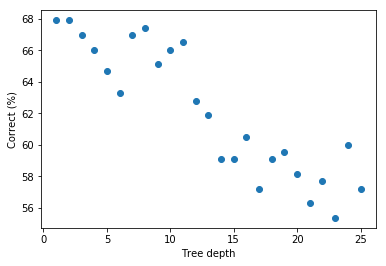

In [14]:
# Decision tree
depths_count = 25
correct_tree = np.zeros(depths_count)
depths = np.arange(1, depths_count + 1)
for i in range(depths_count):
    correct_tree[i] = do_prediction(tree.DecisionTreeClassifier(max_depth = depths[i]), inner_train_args, inner_train_answers, inner_test_args, inner_test_answers)
best_depth = depths[np.argmax(correct_tree)]
clf_tree = tree.DecisionTreeClassifier(max_depth = best_depth)
outer_correct = do_prediction(clf_tree, outer_train_args, outer_train_answers, outer_test_args, outer_test_answers)
print (best_depth, correct_tree[best_depth], outer_correct)

dot_data = tree.export_graphviz(clf_tree, out_file=None, feature_names=outer_train_args.columns)
graph = graphviz.Source(dot_data)
graph.render("tree")

plt.plot(depths, correct_tree * 100, 'o')
plt.xlabel('Tree depth')
plt.ylabel('Correct (%)')
plt.savefig('correct_tree.pdf')

19 0.651162790698 0.644351464435


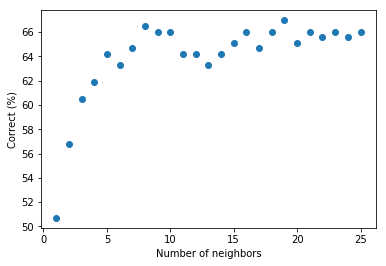

In [12]:
# KNN
n_neighbors = 25
neighbors_count = np.arange(1, n_neighbors + 1)
correct_knn = np.zeros(n_neighbors)
for i in range(n_neighbors):
    correct_knn[i] = do_prediction(neighbors.KNeighborsClassifier(n_neighbors = neighbors_count[i]), inner_train_args, inner_train_answers, inner_test_args, inner_test_answers)
best_k = neighbors_count[np.argmax(correct_knn)]
clf_knn = neighbors.KNeighborsClassifier(n_neighbors = best_k)
outer_correct = do_prediction(clf_knn, outer_train_args, outer_train_answers, outer_test_args, outer_test_answers)
print (best_k, correct_knn[best_k], outer_correct)

plt.plot(neighbors_count, correct_knn * 100, 'o')
plt.xlabel('Number of neighbors')
plt.ylabel('Correct (%)')
plt.savefig('correct_knn.pdf')

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


16 0.669456066946 0.610878661088


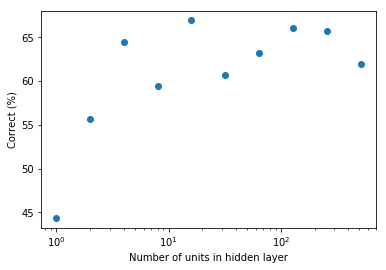

In [11]:
# ANN
correct_ann = np.zeros(10)
n_units = 2 ** (np.arange(len(correct_ann)))
for i in range(len(correct_ann)):
    correct_ann[i] = do_prediction(neural_network.MLPClassifier(hidden_layer_sizes = n_units[i]), outer_train_args, outer_train_answers, outer_test_args, outer_test_answers)
best_i = np.argmax(correct_ann)
clf_ann = neural_network.MLPClassifier(hidden_layer_sizes = n_units[best_i])
outer_correct = do_prediction(clf_ann, outer_train_args, outer_train_answers, outer_test_args, outer_test_answers)
print (n_units[best_i], correct_ann[best_i], outer_correct)

plt.plot(n_units, correct_ann * 100, 'o')
plt.xlabel('Number of units in hidden layer')
plt.ylabel('Correct (%)')
plt.savefig('correct_ann.pdf')